In [1]:
import os
import itertools
import random
import data_pipeline as pipeline
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
PROCESSED_DIR = "../data/processed"
IMG_HEIGHT = IMG_WIDTH = 128
NUM_CHANNELS = 3
NUM_CLASSES = 2
EPOCHS = 30
BATCH_SIZE = 128

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [4]:
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
]

In [5]:
train_dir = os.path.join(PROCESSED_DIR, "train")
val_dir = os.path.join(PROCESSED_DIR, "val")
test_dir = os.path.join(PROCESSED_DIR, "test")

all_paths = pipeline.get_image_paths(PROCESSED_DIR)
train_paths = [path for path in all_paths if "/train/" in path]
mean, std = pipeline.calc_mean_std(train_paths)

# use generators from data_pipeline for training, validation, and testing
print("loading train/val/test generators from data_pipeline")
train_data_gen, val_data_gen, test_data_gen, test_data_gen_raw = pipeline.load_data(
    train_dir, val_dir, test_dir, mean, std
)

loading train/val/test generators from data_pipeline
creating train generator
Found 1600 images belonging to 2 classes.
creating validation generator
Found 400 images belonging to 2 classes.
creating test generator (normalized)
Found 200 images belonging to 2 classes.
creating test generator (raw)
Found 200 images belonging to 2 classes.


In [6]:
image_size = (IMG_HEIGHT, IMG_WIDTH)
input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

In [7]:
class_names = list(train_data_gen.class_indices.keys())
print(f"class names found: {class_names}")

class names found: ['COVID', 'NORMAL']


In [8]:
def build_model(input_shape):
    """
    build keras sequential model

    params
    ------
    input_shape: tuple
        shape of input images (height, width, channels)

    returns
    -------
    model: tf.keras.Model
        compiled keras model
    """
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=input_shape),
            # convolutional
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            # fully connected
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),  # random value
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.3),  # random value
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    return model

In [9]:
def train_model(model, train_data, val_data, epochs=30):
    # compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=metrics,
    )
    # train the model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
    )
    return history

In [10]:
# build model
model = build_model(input_shape)

# print model summary
print("model architecture:")
model.summary()

model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,296,001 (16.39 MB)

 Trainable params: 4,296,001 (16.39 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# train the model
history = train_model(model, train_data_gen, val_data_gen, EPOCHS)

/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 0.5357 - loss: 0.7813 - precision: 0.5309 - recall: 0.6896 - val_accuracy: 0.5950 - val_loss: 0.6763 - val_precision: 0.6000 - val_recall: 0.5700
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 578ms/step - accuracy: 0.7055 - loss: 0.5811 - precision: 0.7024 - recall: 0.7100 - val_accuracy: 0.6025 - val_loss: 0.6556 - val_precision: 0.5911 - val_recall: 0.6650
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 576ms/step - accuracy: 0.7382 - loss: 0.5497 - precision: 0.7330 - recall: 0.7651 - val_accuracy: 0.6450 - val_loss: 0.6266 - val_precision: 0.6318 - val_recall: 0.6950
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 580ms/step - accuracy: 0.7557 - loss: 0.5125 - precision: 0.7489 - recall: 0.7722 - val_accuracy: 0.7025 - val_loss: 0.5690 - val_precision: 0.6957 - val_recall: 0.7200
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 586ms/step - accuracy: 0.7576 - loss: 0.5055 - precision: 0.7698 - recall: 0.6994 - val_accuracy: 0.6975 - val_loss: 0.

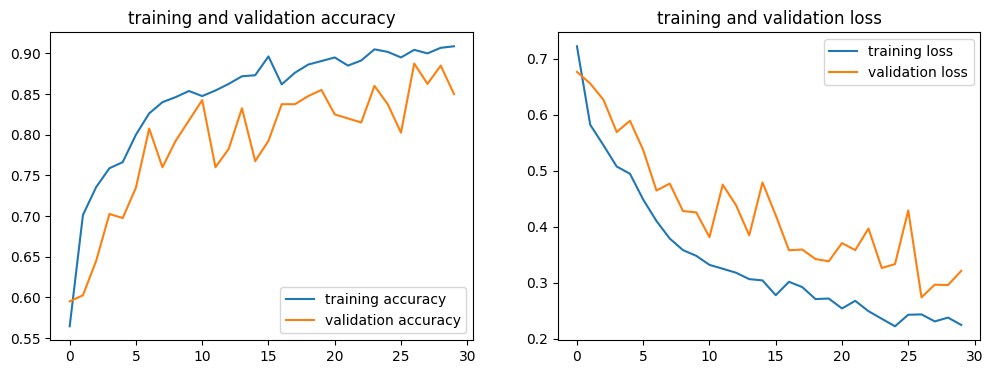

In [12]:
# plot training history
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="training accuracy")
plt.plot(epochs_range, val_acc, label="validation accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="training loss")
plt.plot(epochs_range, val_loss, label="validation loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")
plt.show()

In [13]:
# evaluate the model on the validation set after training
print("\nevaluating model on validation data after training...")
results = model.evaluate(val_data_gen, verbose=1)
print(f"final validation loss: {results[0]}")
print(f"final validation accuracy: {results[1]}")
print(f"final validation precision: {results[2]}")
print(f"final validation recall: {results[3]}")


evaluating model on validation data after training...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8418 - loss: 0.3548 - precision: 0.5947 - recall: 0.7426      
final validation loss: 0.3212575912475586
final validation accuracy: 0.8500000238418579
final validation precision: 0.8097345232963562
final validation recall: 0.9150000214576721


# with hyperparam tuning

In [14]:
def build_model(input_shape, filters_conv1, units_dense1, dropout_rate):
    """
    build keras sequential model

    params
    ------
    input_shape: tuple
        shape of input images (height, width, channels)
    filters_conv1: int
        number of filters in the first convolutional layer
    units_dense1: int
        number of units in the first dense layer
    dropout_rate: float
        dropout rate for dropout layers

    returns
    -------
    model: tf.keras.Model
        keras model (not compiled)
    """
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=input_shape),
            # convolutional
            tf.keras.layers.Conv2D(
                filters_conv1, (3, 3), activation="relu", padding="same"
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            # fully connected
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units_dense1, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
    return model


In [15]:
# define search space
learning_rates = [1e-3, 1e-4, 1e-5]
filters_conv1_list = [16, 32, 64]
units_dense1_list = [64, 128, 256]
dropout_rates = [0.2, 0.3, 0.4, 0.5]

In [16]:
# create all possible combinations (full grid)
param_grid = list(
    itertools.product(
        learning_rates, filters_conv1_list, units_dense1_list, dropout_rates
    )
)

In [17]:
# define number of combinations to randomly sample
num_combinations_to_test = 10

In [18]:
# randomly sample combinations
if len(param_grid) > num_combinations_to_test:
    sampled_params = random.sample(param_grid, num_combinations_to_test)
    print(
        f"randomly sampling {num_combinations_to_test} combinations from {len(param_grid)} total."
    )
else:
    sampled_params = param_grid
    print(
        f"running all {len(param_grid)} combinations (less than or equal to sample size)."
    )

randomly sampling 10 combinations from 108 total.


In [19]:
# store results
results_list = []

In [20]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

In [21]:
print("starting hyperparameter tuning")

for lr, filters1, units1, dr in sampled_params:
    print(
        f"testing: lr={lr}, filters_conv1={filters1}, units_dense1={units1}, dropout_rate={dr}"
    )

    # build model
    input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    model = build_model(
        input_shape,
        filters_conv1=filters1,
        units_dense1=units1,
        dropout_rate=dr,
    )

    # compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

    # train the model
    history = model.fit(
        train_data_gen,
        epochs=EPOCHS,
        validation_data=val_data_gen,
        callbacks=[early_stopping],
        verbose=0,
    )

    # evaluate the model on the validation set using best weights from early stopping
    print("evaluating best model from this run")
    eval_results = model.evaluate(val_data_gen, verbose=1)

    run_results = {
        "learning_rate": lr,
        "filters_conv1": filters1,
        "units_dense1": units1,
        "dropout_rate": dr,
        "val_loss": eval_results[0],
        "val_accuracy": eval_results[1],
        "val_precision": eval_results[2],
        "val_recall": eval_results[3],
        "epochs_trained": len(history.epoch),
    }
    results_list.append(run_results)

print("hyperparameter tuning finished.")

starting hyperparameter tuning
testing: lr=0.001, filters_conv1=16, units_dense1=64, dropout_rate=0.2
Restoring model weights from the end of the best epoch: 25.
evaluating best model from this run
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8825 - loss: 0.3028 - precision: 0.6777 - recall: 0.6887       
testing: lr=0.0001, filters_conv1=16, units_dense1=128, dropout_rate=0.4
Restoring model weights from the end of the best epoch: 29.
evaluating best model from this run
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8182 - loss: 0.4009 - precision: 0.5945 - recall: 0.6586       
testing: lr=1e-05, filters_conv1=64, units_dense1=64, dropout_rate=0.4
Restoring model weights from the end of the best epoch: 30.
evaluating best model from this run
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6544 - loss: 0.5986 - precision: 0.4530 - recall: 0.5964      
testing: lr=0.001, filters_conv1=32, units_dense1=128, dropout_rate=0.2
Restoring model weights from the end of the be

In [22]:
# convert results to dataframe
results_df = pd.DataFrame(results_list)

# sort by validation accuracy (descending)
results_df = results_df.sort_values(by="val_accuracy", ascending=False)

# print results
print("\ntuning results summary:")
print(results_df)

# save results to csv
results_filename = "hyperparameter_tuning_results_random_search.csv"
results_df.to_csv(results_filename, index=False)
print(f"\nresults saved to {results_filename}")


tuning results summary:
   learning_rate  filters_conv1  units_dense1  dropout_rate  val_loss  \
3        0.00100             32           128           0.2  0.299479   
6        0.00100             32           256           0.2  0.258365   
0        0.00100             16            64           0.2  0.304306   
5        0.00100             64           256           0.3  0.334200   
8        0.00010             32           256           0.2  0.362484   
9        0.00010             64           256           0.4  0.398781   
1        0.00010             16           128           0.4  0.400087   
4        0.00001             16           256           0.3  0.537204   
7        0.00001             32           256           0.4  0.537078   
2        0.00001             64            64           0.4  0.586726   

   val_accuracy  val_precision  val_recall  epochs_trained  
3        0.8850       0.850000       0.935              30  
6        0.8825       0.884422       0.880       

In [23]:
# we have to reload the data, we created a train_val folder for ease of use
train_val_dir = os.path.join(PROCESSED_DIR, "train_val")

train_val_data_gen, val_data_gen, test_data_gen, test_data_gen_raw = pipeline.load_data(
    train_val_dir, val_dir, test_dir, mean, std
)  # NB: we don't actually need the validation data gen that is created here

creating train generator
Found 2000 images belonging to 2 classes.
creating validation generator
Found 400 images belonging to 2 classes.
creating test generator (normalized)
Found 200 images belonging to 2 classes.
creating test generator (raw)
Found 200 images belonging to 2 classes.


In [24]:
print("\nretraining the best model on the combined train+validation data")
best_params = results_df.iloc[0]
best_lr = best_params["learning_rate"]
best_filters_conv1 = int(
    best_params["filters_conv1"]
)  # cast to int, wasn't working before
best_units_dense1 = int(
    best_params["units_dense1"]
)  # cast to int, wasn't working before
best_dropout_rate = best_params["dropout_rate"]
print(
    f"best hyperparameters found: lr={best_lr}, filters_conv1={best_filters_conv1}, units_dense1={best_units_dense1}, dropout_rate={best_dropout_rate}"
)


retraining the best model on the combined train+validation data
best hyperparameters found: lr=0.001, filters_conv1=32, units_dense1=128, dropout_rate=0.2


In [25]:
# build the best model
final_model = build_model(
    input_shape,
    filters_conv1=best_filters_conv1,
    units_dense1=best_units_dense1,
    dropout_rate=best_dropout_rate,
)

# compile the best model
optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
final_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

# train the best model on the combined train+val data
final_history = final_model.fit(
    train_val_data_gen,
    epochs=EPOCHS,
    verbose=1,  # show progress for final training
)

/opt/anaconda3/envs/ml-2025/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 563ms/step - accuracy: 0.6395 - loss: 0.9213 - precision: 0.6400 - recall: 0.6489
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 0.7076 - loss: 0.5919 - precision: 0.6840 - recall: 0.7582
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.7128 - loss: 0.5641 - precision: 0.6943 - recall: 0.7478
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 548ms/step - accuracy: 0.7516 - loss: 0.5009 - precision: 0.7381 - recall: 0.7696
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 560ms/step - accuracy: 0.7960 - loss: 0.4565 - precision: 0.7915 - recall: 0.7944
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 558ms/step - accuracy: 0.8195 - loss: 0.4047 - precision: 0.8218 - recall: 0.8101
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 556ms/step - accuracy: 0.8133 - loss: 0.3986 - precision: 0.8453 - recall: 0.7698
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.8090 - loss: 0.3837 - precision: 0.8257 - recall: 0.7875
Epoch 9/30
16/1


plotting final training history


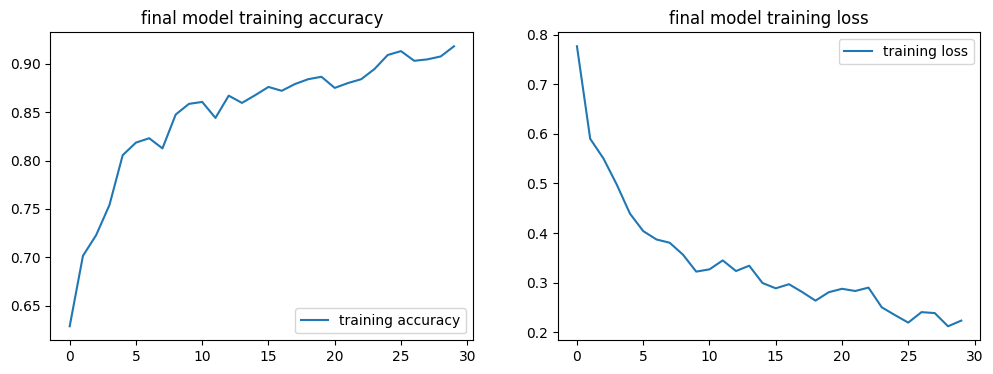

In [26]:
print("\nplotting final training history")
final_acc = final_history.history["accuracy"]
final_loss = final_history.history["loss"]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, final_acc, label="training accuracy")
plt.legend(loc="lower right")
plt.title("final model training accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, final_loss, label="training loss")
plt.legend(loc="upper right")
plt.title("final model training loss")
plt.show()

In [27]:
model_save_path = "final_covid_xray_model.keras"
print(f"\nsaving final model to {model_save_path}")
final_model.save(model_save_path)

print("loading model back")
loaded_model = tf.keras.models.load_model(model_save_path)
print("model loaded successfully")


saving final model to final_covid_xray_model.keras
loading model back
model loaded successfully


In [28]:
print("\nevaluating loaded model on test data...")
test_results = loaded_model.evaluate(test_data_gen, verbose=1)
print(f"test loss: {test_results[0]}")
print(f"test accuracy: {test_results[1]}")
print(f"test precision: {test_results[2]}")
print(f"test recall: {test_results[3]}")


evaluating loaded model on test data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8542 - loss: 0.3788 - precision: 0.7161 - recall: 0.9933
test loss: 0.3287671208381653
test accuracy: 0.875
test precision: 0.8048780560493469
test recall: 0.9900000095367432



generating confusion matrix...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


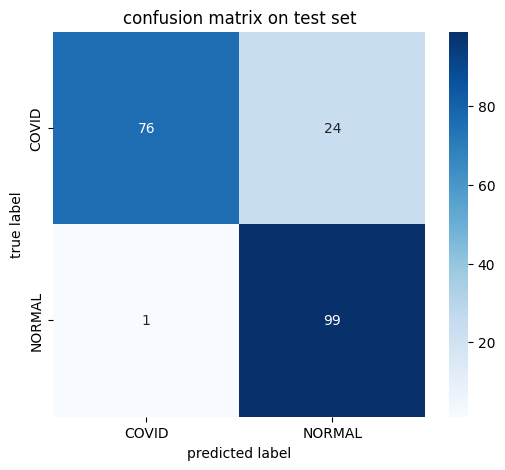

In [29]:
print("\ngenerating confusion matrix...")
# get predictions (probabilities)
y_pred_prob = loaded_model.predict(test_data_gen)
# convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
# get true labels
y_true = test_data_gen.classes
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.title("confusion matrix on test set")
plt.show()


plotting sample test images with predictions
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


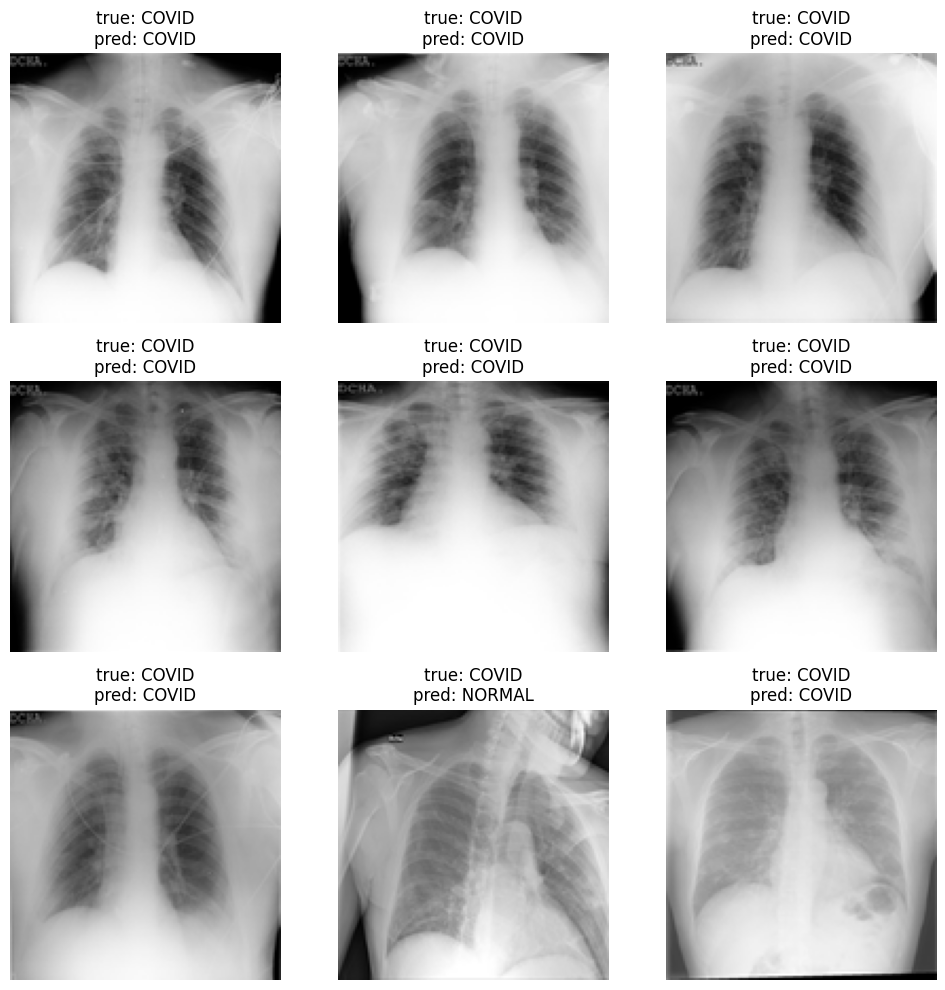

In [30]:
print("\nplotting sample test images with predictions")
# get a batch of raw (unnormalized) images and labels
images_raw, labels_raw = next(iter(test_data_gen_raw))
# get predictions for this batch using the normalized data generator
# important: ensure we use the *same batch* for predictions
# we need to reset the generator to be sure we get the same batch
test_data_gen.reset()
images_norm, _ = next(iter(test_data_gen))  # get normalized images for prediction
batch_pred_prob = loaded_model.predict(images_norm)
batch_pred = (batch_pred_prob > 0.5).astype(int).flatten()

plt.figure(figsize=(10, 10))
for i in range(9):  # display 9 samples
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_raw[i].astype("uint8"))  # display raw image
    true_label = class_names[int(labels_raw[i])]  # cast to int
    pred_label = class_names[batch_pred[i]]
    plt.title(f"true: {true_label}\npred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()